<a href="https://colab.research.google.com/github/arshad62/learn-agentic-ai/blob/main/12_langchain_ecosystem/langgraph/course-notebooks/module-2/6.1_chatbot_external_memory_with_our_db_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer.

We've also shown a number of tricks for trimming or filtering messages in graph state.

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases.

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

## Use Cases for Database File Management:
1. Fetching a Database File from a GitHub URL
2. Uploading a Database File from Your Local System
3. Accessing a Database File from Google Drive

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_google_genai

In [2]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [3]:
import os
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database.

If we supply `":memory:"` it creates an in-memory Sqlite database.

In [4]:
import sqlite3
# In memory - temporary database is created, not on-disk database
conn = sqlite3.connect(":memory:", check_same_thread = False) #check_same_thread = False | allowing multiple threads to share and use the same SQLite database connection. By default it is True

## Default Behavior:

When you run the code for the first time, it will automatically fetch a new example.db file for you.
But, if we supply a db path, then it will create a database for us!:

In [5]:
import sqlite3
# pull file if it doesn't exist and connect to local db

!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

--2025-01-05 07:12:57--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-01-05 07:12:57--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.02s   

2025-01-05 07:12:58 (4.51 MB/s) - ‘s

## Mount with Google Drive


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


connection is establish

In [6]:
import sqlite3
file_path = '/content/drive/My Drive/state_db/example.db'
conn = sqlite3.connect(file_path)

### When you want to pass your DB file:
You need example.db as well as example.db-wal file to retrieve your previous data.

Sqlite uses these 3 files:


1.   example.db
2.   example.db-wal
3.   example.db-shm

### How SQLite Uses These Files
1. example.db:
  This is the main database file where committed data is stored.

2. example.db-wal:
  If SQLite is in WAL mode, this file temporarily holds changes that
  have not been checkpointed (written to example.db).
  SQLite automatically reads from this file when you connect to the database.

3. example.db-shm:
  This file is used for shared memory when multiple connections are accessing the same database.
  It is a temporary file and does not affect persistence.



### Why you need to save example.db-wal file along with example.db file?

1. **Uncommitted Changes Are Stored in `example.db-wal`**:
   - In WAL mode, SQLite writes all changes to the `example.db-wal` file instead of directly modifying the main `example.db` file.
   - These changes are only merged (checkpointed) into `example.db` when a checkpoint operation occurs.

   If you only copy or use the `example.db` file without the `example.db-wal`, **any uncommitted changes in the WAL file will be lost.**

2. **Ensures Data Consistency**:
   - If you transfer the database (`example.db`) to another system without the `example.db-wal`, the database may appear incomplete or inconsistent if there are pending writes stored in the WAL file.

3. **Concurrent Access**:
   - The WAL file allows multiple processes to read from the database while another process writes to it, without blocking each other. If this feature is in use, the `example.db-wal` file is essential for proper functionality.



In [7]:
#Follow step if you already have previous database file
#uplaod example.db file from your system
from google.colab import files
uploaded = files.upload()


Saving example.db-wal to example.db-wal
Saving example (3).db to example (3).db
Saving example (2).db to example (2).db
Saving example (1).db to example (1).db
Saving example.db to example.db


In [ ]:
#Follow step if you already have previous database file
#upload example.db-wal file from your system
uploaded = files.upload()


Saving example.db-wal to example.db-wal


In [8]:
#Follow step if you already have previous database file
#move both files to state_db folder and establish a connection:

import sqlite3
import shutil
import os

# Ensure the state_db directory exists
os.makedirs("state_db", exist_ok=True)

# Move the uploaded files to the state_db directory
shutil.move("example.db", "state_db/example.db")
if os.path.exists("example.db-wal"):  # Check if WAL file exists
    shutil.move("example.db-wal", "state_db/example.db-wal")
    print("WAL file moved successfully.")
else:
    print("No WAL file found. Proceeding with example.db only.")

# Define the path to the main database file
db_path = "state_db/example.db"

# Connect to the SQLite database
try:
    conn = sqlite3.connect(db_path, check_same_thread=False)
    print(f"Connected to database: {db_path}")
except sqlite3.OperationalError as e:
    print(f"Error connecting to the database: {e}")


WAL file moved successfully.
Connected to database: state_db/example.db


In [9]:
# Here is our checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

Let's re-define our chatbot.

In [10]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model = "gemini-1.5-flash", api_key =  GEMINI_API_KEY)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State) -> State:

    # Get summary if it exists
    summary = state.get("summary", "")
    print(f"Using summary: {summary}")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    print(f"Messages before summarizing: {len(state['messages'])}")
    # First, we get any existing summary
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    # Summarization logic
    print(f"New summary: {response.content}")

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    print(f"Messages after truncation: {len(delete_messages)}")
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> State:

    """Return the next node to execute."""

    messages = state["messages"]
    print(f"Message count: {len(messages)}")
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

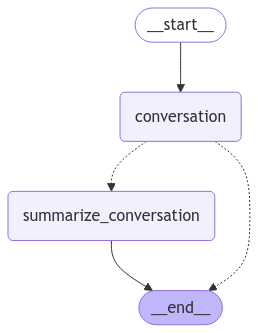

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START
from langgraph.graph.state import CompiledStateGraph

# Define a new graph
workflow: StateGraph = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph: CompiledStateGraph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [19]:
# Create a thread
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="I would like to know about cirket.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: 
Message count: 2
================================== Ai Message ==================================

I assume you mean **cricket**.

Cricket is a bat-and-ball game played between two teams of eleven players on a field at the centre of which is a 22-yard pitch with a wicket at each end.  It's a complex game with a rich history and many variations, but here's a basic overview:

**The Basics:**

* **The Goal:** The batting team tries to score runs, while the bowling team tries to dismiss (get out) the batsmen.
* **The Pitch:** A rectangular area of closely mown grass.
* **The Wicket:** Three wooden stumps with two small bails balanced on top.  This is the target for the bowler.
* **The Bat:** A flat, wooden bat used by the batsmen to hit the ball.
* **The Ball:** A hard, leather-covered ball.

**Gameplay:**

* **Innings:**  A team's turn at batting.  Matches can have one innings per team (like T20), or two innings per team (like Test matches).
* **Bowling:** One bowler from 

Let's confirm that our state is saved locally.

In [20]:
input_message = HumanMessage(content="My name is Arshad.")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 4
================================== Ai Message ==================================

It's nice to meet you, Arshad.  Is there anything I can help you with today regarding cricket or any other topic?


In [21]:
input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()


Using summary: 
Message count: 6
================================== Ai Message ==================================

Your name is Arshad.


In [22]:
input_message = HumanMessage(content="i like the Pakistan Cirket team!")
output = graph.invoke({"messages": [input_message]}, config)
for m in output['messages'][-1:]:
    m.pretty_print()

Using summary: 
Message count: 8
Messages before summarizing: 8
Existing summary: 
New summary: The conversation began with a request for information about cricket.  After clarifying the spelling, a basic explanation of the game was provided.  The user then introduced themselves as Arshad.  A brief exchange confirmed the user's name, and the conversation concluded with Arshad expressing their support for the Pakistan cricket team.

Messages after truncation: 6
================================== Ai Message ==================================

That's great!  Pakistan has a very passionate and talented cricket team with a rich history.  They've produced some legendary players and have always been a force to be reckoned with on the international stage.  Are there any particular players or moments in Pakistan cricket history that you enjoy the most?


In [16]:
config = {"configurable": {"thread_id": "2"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='I would like to know about football.', additional_kwargs={}, response_metadata={}, id='c41d327e-bd95-4c49-8efa-dd6f0fbd6eab'), AIMessage(content="Football, or soccer as it's known in some parts of the world, is a team sport played with a spherical ball between two teams of eleven players.  The objective is to score by getting the ball into the opposing team's goal.  Here's a breakdown of key aspects:\n\n**Gameplay:**\n\n* **The Field:** A rectangular field with goalposts at each end.  The size of the field varies slightly depending on the level of play (professional, amateur, youth).\n* **Scoring:** A goal is scored when the entire ball crosses the goal line between the goalposts and under the crossbar.\n* **Movement:** Players use their feet, head, and chest to control and move the ball.  Hands are only allowed for goalkeepers within their designated area.\n* **Fouls:**  Various actions are considered fouls, such as tripping, pu

In [17]:
config = {"configurable": {"thread_id": "2"}}
messages = graph.get_state(config).values.get("messages")
len(messages)

6

In [18]:
graph_state = graph.get_state(config).values.get("summary","")
graph_state

''

In [19]:
!ls state_db


example.db  example.db-shm  example.db-wal


Download required db files

In [27]:
from google.colab import files
files.download('state_db/example.db')
files.download('state_db/example.db-wal')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Persisting state

Using database like Sqlite means state is persisted!

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Now that we better understand external memory, recall that the LangGraph API packages your code and provides you with with built-in persistence.

And the API is the back-end for Studio!

Load the `chatbot` in the UI, which uses `module2-/studio/chatbot.py` set in `module2-/studio/langgraph.json`.